***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4194)


In [6]:
fin_col=['Target',
 'url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_word_count_info',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8']

In [7]:
# col_no_unique=[]
# for col in df.columns[:-1]:
#     if len(df[col].value_counts())==1:
#         col_no_unique.append(col)

# print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
# display(np.array(col_no_unique))
# ### Drop those columns
# df.drop(col_no_unique,axis=1,inplace=True)

# print("Shape of our dataset after dropping them:",df.shape)

# ext_end=[col for col in df.columns if 'extension_ends' in col]

# for col in ext_end:
#     df[col]=df[col].astype(int)

# # ### Check and converting data types
# # df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
# print("Columns which are of type object:\n",df.dtypes[(df.dtypes=='object')])

# lst=[]
# for col in df.columns[:-1]:
#     lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

# col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
# col_values.set_index('Feature',drop=True,inplace=True)
# del lst

# print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

# columns=col_values[col_values['95_%_same_values']==False].index.values
# columns=columns.tolist()
# col_values['95_%_same_values'].value_counts()

# print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
# columns.remove('url_host')

# rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
# for col in rem:
#     columns.remove(col)

# df_sel=df[columns]

# cat_var_js,num_var_js=check_cat(df_sel)

# print("Stats for numerical features for HTML experiment\n")
# num_stats_js=num_stats(df_sel,num_var_js)
# display(num_stats_js)
# print("\nStats for Categorical features for HTML experiment\n")
# cat_stats_js=cat_stats(df_sel,cat_var_js)
# display(cat_stats_js)

In [8]:
df_sel=df[fin_col]

In [9]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [11]:
columns=fin_col.copy()

In [12]:
columns.remove('Target')

In [13]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [14]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.962396771521
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31805    87    31892
True        1320  4205     5525
__all__    33125  4292    37417

Accuracy of the model for test data is: 0.956809920889
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7958    27     7985
True         377   992     1369
__all__     8335  1019     9354



Logistic Regression
Accuracy of the model for training data is: 0.950263249325
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31480   412    31892
True        1449  4076     5525
__all__    32929  4488    37417

Accuracy of the model for test data is: 0.949967928159
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7862   123     7985
True         345  1024     1369
__all__     8207  1147     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994815190956
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     6    31892
True         188  5337     5525
__all__    32074  5343    37417

Accuracy of the model for test data is: 0.963545007483
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7923    62     7985
True         279  1090     1369
__all__     8202  1152     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.946281102173
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31428   464    31892
True        1546  3979     5525
__all__    32974  4443    37417

Accuracy of the model for test data is: 0.944622621338
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7853   132     7985
True         386   983     1369
__all__     8239  1115     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.958521527648
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31514   378    31892
True        1174  4351     5525
__all__    32688  4729    37417

Accuracy of the model for test data is: 0.957558263844
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7885   100     7985
True         297  1072     1369
__all__     8182  1172     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.961299978619
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7920    65     7985
True         297  1072     1369
__all__     8217  1137     9354



Bagging Classifier
Accuracy of the model for training data is: 0.994147045461
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31883     9    31892
True         210  5315     5525
__all__    32093  5324    37417

Accuracy of the model for test data is: 0.963224289074
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7908    77     7985
True         267  1102     1369
__all__     8175  1179     9354



Neural Network-1
The accuracy of the model on training data is: 0.996685998343


Predicted  False  True  __all__
Actual                         
False      31872    20    31892
True         104  5421     5525
__all__    31976  5441    37417

The accuracy of the model on test data is: 0.956061577935


Predicted  False  True  __all__
Actual                         
False       7809   176     7985
True         235  1134     1369
__all__     8044  1310     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [15]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [16]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.962397,4205.0,31805.0,87.0,1320.0,0.002728,0.238914
LogisticRegression,0.950263,4076.0,31480.0,412.0,1449.0,0.012919,0.262262
RandomForestClassifier,0.994815,5337.0,31886.0,6.0,188.0,0.000188,0.034027
AdaBoostClassifier,0.946281,3979.0,31428.0,464.0,1546.0,0.014549,0.279819
GradientBoostingClassifier,0.958522,4351.0,31514.0,378.0,1174.0,0.011853,0.212489
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994147,5315.0,31883.0,9.0,210.0,0.000282,0.038009
Neural Network-1,0.996686,5421.0,31872.0,20.0,104.0,0.000627,0.018824


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.956810,992.0,7958.0,27.0,377.0,0.003381,0.275383,0.860618,0.818231
LogisticRegression,0.949968,1024.0,7862.0,123.0,345.0,0.015404,0.252009,0.866294,0.789450
RandomForestClassifier,0.963545,1090.0,7923.0,62.0,279.0,0.007765,0.203798,0.894219,0.848047
AdaBoostClassifier,0.944623,983.0,7853.0,132.0,386.0,0.016531,0.281958,0.850756,0.765243
GradientBoostingClassifier,0.957558,1072.0,7885.0,100.0,297.0,0.012523,0.216947,0.885265,0.822688
ExtraTreeClassifier,0.961300,1072.0,7920.0,65.0,297.0,0.008140,0.216947,0.887457,0.838215
BaggingClassifier,0.963224,1102.0,7908.0,77.0,267.0,0.009643,0.195033,0.897662,0.846998
Neural Network-1,0.956062,1134.0,7809.0,176.0,235.0,0.022041,0.171658,0.897662,0.821229


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [17]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [18]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [19]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [20]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.976310673523
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30406   1486    31892
True          25  31867    31892
__all__    30431  33353    63784

Accuracy of the model for test data is: 0.918751336327
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7412   573     7985
True         187  1182     1369
__all__     7599  1755     9354



Logistic Regression
Accuracy of the model for training data is: 0.893766461809
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29539   2353    31892
True        4423  27469    31892
__all__    33962  29822    63784

Accuracy of the model for test data is: 0.917254650417
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7382   603     7985
True         171  1198     1369
__all__     7553  1801     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.997899159664
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31887      5    31892
True         129  31763    31892
__all__    32016  31768    63784

Accuracy of the model for test data is: 0.961941415437
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7887    98     7985
True         258  1111     1369
__all__     8145  1209     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.936488774614
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30318   1574    31892
True        2477  29415    31892
__all__    32795  30989    63784

Accuracy of the model for test data is: 0.92997648065
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7569   416     7985
True         239  1130     1369
__all__     7808  1546     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.964536560893
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31072    820    31892
True        1442  30450    31892
__all__    32514  31270    63784

Accuracy of the model for test data is: 0.947615993158
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7749   236     7985
True         254  1115     1369
__all__     8003  1351     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999984322087
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31892      0    31892
True           1  31891    31892
__all__    31893  31891    63784

Accuracy of the model for test data is: 0.964079538165
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7920    65     7985
True         271  1098     1369
__all__     8191  1163     9354



Bagging Classifier
Accuracy of the model for training data is: 0.996989840712
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31880     12    31892
True         180  31712    31892
__all__    32060  31724    63784

Accuracy of the model for test data is: 0.957878982254
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7853   132     7985
True         262  1107     1369
__all__     8115  1239     9354



Neural Network-1
The accuracy of the model on training data is: 0.997209331494


Predicted  False   True  __all__
Actual                          
False      31837     55    31892
True         123  31769    31892
__all__    31960  31824    63784

The accuracy of the model on test data is: 0.947188368612


Predicted  False  True  __all__
Actual                         
False       7721   264     7985
True         230  1139     1369
__all__     7951  1403     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [21]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [22]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.976311,31867.0,30406.0,1486.0,25.0,0.046595,0.000784
LogisticRegression,0.893766,27469.0,29539.0,2353.0,4423.0,0.073780,0.138687
RandomForestClassifier,0.997899,31763.0,31887.0,5.0,129.0,0.000157,0.004045
AdaBoostClassifier,0.936489,29415.0,30318.0,1574.0,2477.0,0.049354,0.077668
GradientBoostingClassifier,0.964537,30450.0,31072.0,820.0,1442.0,0.025712,0.045215
ExtraTreeClassifier,0.999984,31891.0,31892.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.996990,31712.0,31880.0,12.0,180.0,0.000376,0.005644
Neural Network-1,0.997209,31769.0,31837.0,55.0,123.0,0.001725,0.003857


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.918751,1182.0,7412.0,573.0,187.0,0.071760,0.136596,0.895822,0.716725
LogisticRegression,0.917255,1198.0,7382.0,603.0,171.0,0.075517,0.124909,0.899787,0.716773
RandomForestClassifier,0.961941,1111.0,7887.0,98.0,258.0,0.012273,0.188459,0.899634,0.842118
AdaBoostClassifier,0.929976,1130.0,7569.0,416.0,239.0,0.052098,0.174580,0.886661,0.735911
GradientBoostingClassifier,0.947616,1115.0,7749.0,236.0,254.0,0.029555,0.185537,0.892454,0.789230
ExtraTreeClassifier,0.964080,1098.0,7920.0,65.0,271.0,0.008140,0.197955,0.896953,0.850451
BaggingClassifier,0.957879,1107.0,7853.0,132.0,262.0,0.016531,0.191381,0.896044,0.825910
Neural Network-1,0.947188,1139.0,7721.0,264.0,230.0,0.033062,0.168006,0.896044,0.790878


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [23]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [24]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 38)


In [25]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [26]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.915656108597
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5409   116     5525
True         816  4709     5525
__all__     6225  4825    11050

Accuracy of the model for test data is: 0.944836433611
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7726   259     7985
True         257  1112     1369
__all__     7983  1371     9354



Logistic Regression
Accuracy of the model for training data is: 0.898552036199
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5144   381     5525
True         740  4785     5525
__all__     5884  5166    11050

Accuracy of the model for test data is: 0.9201411161
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7409   576     7985
True         171  1198     1369
__all__     7580  1774     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.990678733032
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5515    10     5525
True          93  5432     5525
__all__     5608  5442    11050

Accuracy of the model for test data is: 0.938635877699
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7592   393     7985
True         181  1188     1369
__all__     7773  1581     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.891945701357
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5056   469     5525
True         725  4800     5525
__all__     5781  5269    11050

Accuracy of the model for test data is: 0.902180885183
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7242   743     7985
True         172  1197     1369
__all__     7414  1940     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.90742081448
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5229   296     5525
True         727  4798     5525
__all__     5956  5094    11050

Accuracy of the model for test data is: 0.926448578148
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7477   508     7985
True         180  1189     1369
__all__     7657  1697     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999909502262
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           1  5524     5525
__all__     5526  5524    11050

Accuracy of the model for test data is: 0.936283942698
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7570   415     7985
True         181  1188     1369
__all__     7751  1603     9354



Bagging Classifier
Accuracy of the model for training data is: 0.990497737557
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5518     7     5525
True          98  5427     5525
__all__     5616  5434    11050

Accuracy of the model for test data is: 0.930404105196
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7518   467     7985
True         184  1185     1369
__all__     7702  1652     9354



Neural Network-1
The accuracy of the model on training data is: 0.999457013575


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           6  5519     5525
__all__     5531  5519    11050

The accuracy of the model on test data is: 0.889031430404


Predicted  False  True  __all__
Actual                         
False       7102   883     7985
True         155  1214     1369
__all__     7257  2097     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [27]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [28]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.915656,4709.0,5409.0,116.0,816.0,0.020995,0.147692
LogisticRegression,0.898552,4785.0,5144.0,381.0,740.0,0.068959,0.133937
RandomForestClassifier,0.990679,5432.0,5515.0,10.0,93.0,0.001810,0.016833
AdaBoostClassifier,0.891946,4800.0,5056.0,469.0,725.0,0.084887,0.131222
GradientBoostingClassifier,0.907421,4798.0,5229.0,296.0,727.0,0.053575,0.131584
ExtraTreeClassifier,0.999910,5524.0,5525.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.990498,5427.0,5518.0,7.0,98.0,0.001267,0.017738
Neural Network-1,0.999457,5519.0,5525.0,0.0,6.0,0.000000,0.001086


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.944836,1112.0,7726.0,259.0,257.0,0.032436,0.187728,0.889918,0.779365
LogisticRegression,0.920141,1198.0,7409.0,576.0,171.0,0.072135,0.124909,0.901478,0.723968
RandomForestClassifier,0.938636,1188.0,7592.0,393.0,181.0,0.049217,0.132213,0.909285,0.772030
AdaBoostClassifier,0.902181,1197.0,7242.0,743.0,172.0,0.093049,0.125639,0.890656,0.681140
GradientBoostingClassifier,0.926449,1189.0,7477.0,508.0,180.0,0.063619,0.131483,0.902449,0.738261
ExtraTreeClassifier,0.936284,1188.0,7570.0,415.0,181.0,0.051972,0.132213,0.907907,0.765217
BaggingClassifier,0.930404,1185.0,7518.0,467.0,184.0,0.058485,0.134405,0.903555,0.748110
Neural Network-1,0.889031,1214.0,7102.0,883.0,155.0,0.110582,0.113221,0.903555,0.657859


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [29]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [30]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [31]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2850 features
EntitySet scattered to workers in 4.639 seconds
Elapsed: 00:23 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [32]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [33]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [34]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [35]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [36]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [37]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [38]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [39]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 43)

In [40]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_w * url_extensions',
 'url_char_. + url_char_w',
 'url_length + url_words_with_length_8',
 'url_length + url_words_with_length_7',
 'url_length + url_words_with_length_5',
 'url_length + url_words_with_length_4',
 'url_length + url_word_count_info',
 'url_length + url_tlds',
 'url_length',
 'url_extensions + url_length',
 'url_extension_.net + url_length',
 'url_extension_.com + url_length',
 'url_char_z + url_length',
 'url_char_y + url_length',
 'url_char_x + url_length',
 'url_char_w + url_words_with_length_8',
 'url_char_w + url_words_with_length_7',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_y',
 'url_char_w + url_char_x',
 'url_char_v + url_length',
 'url_char_s + url_length',
 'url_char_p + url_length',
 'url_char_n + url_length',
 'url_char_l + url_length',
 'url_char_k + url_length',
 'url_char_j + url_length',
 'url_char_i + url_length',
 'url_char_h + url_length',
 'url_char_g + url_length',
 'url_char_f + url_length',
 'ur

In [41]:
fs=fs.reindex(df_sel.index.values)

In [42]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [43]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [44]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.960178528476
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31498   394    31892
True        1096  4429     5525
__all__    32594  4823    37417

Accuracy of the model for test data is: 0.95114389566
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7835   150     7985
True         307  1062     1369
__all__     8142  1212     9354



Logistic Regression
Accuracy of the model for training data is: 0.943261084534
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31454   438    31892
True        1685  3840     5525
__all__    33139  4278    37417

Accuracy of the model for test data is: 0.942805217019
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7854   131     7985
True         404   965     1369
__all__     8258  1096     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994013416362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     6    31892
True         218  5307     5525
__all__    32104  5313    37417

Accuracy of the model for test data is: 0.955847765662
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7876   109     7985
True         304  1065     1369
__all__     8180  1174     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.936686532859
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31326   566    31892
True        1803  3722     5525
__all__    33129  4288    37417

Accuracy of the model for test data is: 0.936711567244
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7835   150     7985
True         442   927     1369
__all__     8277  1077     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.947457038245
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31321   571    31892
True        1395  4130     5525
__all__    32716  4701    37417

Accuracy of the model for test data is: 0.944194996793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7828   157     7985
True         365  1004     1369
__all__     8193  1161     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999732741802
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True          10  5515     5525
__all__    31902  5515    37417

Accuracy of the model for test data is: 0.95531323498
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7871   114     7985
True         304  1065     1369
__all__     8175  1179     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993505625785
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31877    15    31892
True         228  5297     5525
__all__    32105  5312    37417

Accuracy of the model for test data is: 0.953602736797
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7846   139     7985
True         295  1074     1369
__all__     8141  1213     9354



Neural Network-1
The accuracy of the model on training data is: 0.967982467862


Predicted  False  True  __all__
Actual                         
False      31660   232    31892
True         966  4559     5525
__all__    32626  4791    37417

The accuracy of the model on test data is: 0.9594825743


Predicted  False  True  __all__
Actual                         
False       7874   111     7985
True         268  1101     1369
__all__     8142  1212     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [45]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.960179,4429.0,31498.0,394.0,1096.0,0.012354,0.198371
LogisticRegression,0.943261,3840.0,31454.0,438.0,1685.0,0.013734,0.304977
RandomForestClassifier,0.994013,5307.0,31886.0,6.0,218.0,0.000188,0.039457
AdaBoostClassifier,0.936687,3722.0,31326.0,566.0,1803.0,0.017747,0.326335
GradientBoostingClassifier,0.947457,4130.0,31321.0,571.0,1395.0,0.017904,0.252489
ExtraTreeClassifier,0.999733,5515.0,31892.0,0.0,10.0,0.000000,0.001810
BaggingClassifier,0.993506,5297.0,31877.0,15.0,228.0,0.000470,0.041267
Neural Network-1,0.967982,4559.0,31660.0,232.0,966.0,0.007275,0.174842


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.951144,1062.0,7835.0,150.0,307.0,0.018785,0.224251,0.878482,0.796704
LogisticRegression,0.942805,965.0,7854.0,131.0,404.0,0.016406,0.295106,0.844244,0.756647
RandomForestClassifier,0.955848,1065.0,7876.0,109.0,304.0,0.013651,0.222060,0.882145,0.815429
AdaBoostClassifier,0.936712,927.0,7835.0,150.0,442.0,0.018785,0.322863,0.829176,0.729042
GradientBoostingClassifier,0.944195,1004.0,7828.0,157.0,365.0,0.019662,0.266618,0.856860,0.765120
ExtraTreeClassifier,0.955313,1065.0,7871.0,114.0,304.0,0.014277,0.222060,0.881832,0.813280
BaggingClassifier,0.953603,1074.0,7846.0,139.0,295.0,0.017408,0.215486,0.883553,0.807097
Neural Network-1,0.959483,1101.0,7874.0,111.0,268.0,0.013901,0.195763,0.883553,0.831829


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [48]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

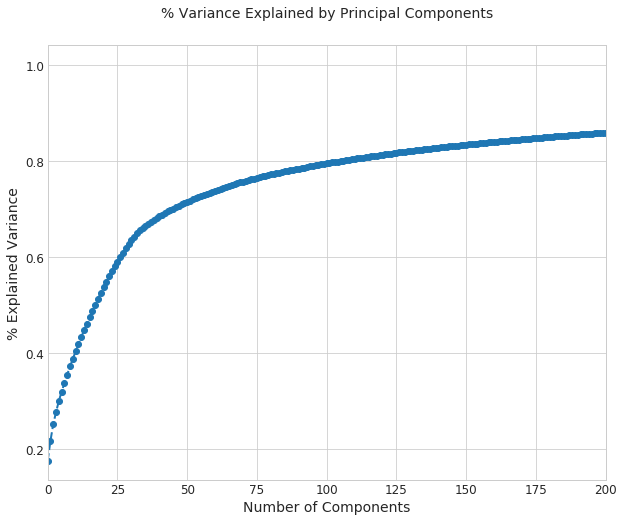

In [49]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [50]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

array([ 105,  106,  107, ..., 2847, 2848, 2849])

In [51]:
pca=PCA(n_components=110,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 110 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 110 components is: 0.80384895696


In [52]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [53]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,110).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.947884651362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31841    51    31892
True        1899  3626     5525
__all__    33740  3677    37417

Accuracy of the model for test data is: 0.938208253154
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7966    19     7985
True         559   810     1369
__all__     8525   829     9354



Logistic Regression
Accuracy of the model for training data is: 0.952748750568
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31470   422    31892
True        1346  4179     5525
__all__    32816  4601    37417

Accuracy of the model for test data is: 0.951464614069
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7862   123     7985
True         331  1038     1369
__all__     8193  1161     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.993906513082
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31885     7    31892
True         221  5304     5525
__all__    32106  5311    37417

Accuracy of the model for test data is: 0.943125935429
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7902    83     7985
True         449   920     1369
__all__     8351  1003     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.937621936553
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31247   645    31892
True        1689  3836     5525
__all__    32936  4481    37417

Accuracy of the model for test data is: 0.934573444516
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7806   179     7985
True         433   936     1369
__all__     8239  1115     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.95392468664
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31596   296    31892
True        1428  4097     5525
__all__    33024  4393    37417

Accuracy of the model for test data is: 0.948364336113
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7885   100     7985
True         383   986     1369
__all__     8268  1086     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.935749412016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7921    64     7985
True         537   832     1369
__all__     8458   896     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993452174145
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31885     7    31892
True         238  5287     5525
__all__    32123  5294    37417

Accuracy of the model for test data is: 0.946333119521
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7883   102     7985
True         400   969     1369
__all__     8283  1071     9354



Neural Network-1
The accuracy of the model on training data is: 0.997594676217


Predicted  False  True  __all__
Actual                         
False      31857    35    31892
True          55  5470     5525
__all__    31912  5505    37417

The accuracy of the model on test data is: 0.953068206115


Predicted  False  True  __all__
Actual                         
False       7790   195     7985
True         244  1125     1369
__all__     8034  1320     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [54]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [55]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.947885,3626.0,31841.0,51.0,1899.0,0.001599,0.343710
LogisticRegression,0.952749,4179.0,31470.0,422.0,1346.0,0.013232,0.243620
RandomForestClassifier,0.993907,5304.0,31885.0,7.0,221.0,0.000219,0.040000
AdaBoostClassifier,0.937622,3836.0,31247.0,645.0,1689.0,0.020225,0.305701
GradientBoostingClassifier,0.953925,4097.0,31596.0,296.0,1428.0,0.009281,0.258462
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993452,5287.0,31885.0,7.0,238.0,0.000219,0.043077
Neural Network-1,0.997595,5470.0,31857.0,35.0,55.0,0.001097,0.009955


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.938208,810.0,7966.0,19.0,559.0,0.002379,0.408327,0.794647,0.732903
LogisticRegression,0.951465,1038.0,7862.0,123.0,331.0,0.015404,0.241782,0.871407,0.796309
RandomForestClassifier,0.943126,920.0,7902.0,83.0,449.0,0.010394,0.327977,0.830814,0.755847
AdaBoostClassifier,0.934573,936.0,7806.0,179.0,433.0,0.022417,0.316289,0.830647,0.721371
GradientBoostingClassifier,0.948364,986.0,7885.0,100.0,383.0,0.012523,0.279766,0.853855,0.780871
ExtraTreeClassifier,0.935749,832.0,7921.0,64.0,537.0,0.008015,0.392257,0.799864,0.720287
BaggingClassifier,0.946333,969.0,7883.0,102.0,400.0,0.012774,0.292184,0.847521,0.771546
Neural Network-1,0.953068,1125.0,7790.0,195.0,244.0,0.024421,0.178232,0.847521,0.809531


In [56]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')